### Option Mispricing

You are given a Black-Scholes options pricer and dirty options data. You need to:

1. Use an optimizer to backout the implied volatility
2. Fit a curve to the implied volalities
3. Use the fitted curve to interpolate volalities
4. Contruct a portfolio for arbitrage

In [227]:
# Timeseries
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Analytics
from scipy import optimize
from scipy.stats import norm

# Utilities
from functools import partial
from dataclasses import dataclass
from typing import List, Dict

# Pandas options
pd.set_option("display.max_columns", 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)


# Plot settings
plt.rcParams['figure.figsize'] = [20, 10]


class BlackScholes:

    N = norm.cdf
    calendar_days_per_year = 365

    def __init__(self,
                 option_type: str,
                 spot: float,
                 strike: float,
                 years: float,
                 risk_free_rate: float,
                 volatility: float
                 ):
        assert option_type in ['C', 'P']
        self.option_type = option_type

        assert spot >= 0.0
        self.S = spot

        assert strike >= 0.0
        self.K = strike

        assert years >= 0.0
        self.T = years

        assert risk_free_rate >= 0.0
        self.r = risk_free_rate

        assert volatility >= 0.0
        self.sigma = volatility

    @property
    def d1(self):
        return (np.log(self.S / self.K) + (self.r + self.sigma ** 2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))

    @property
    def d2(self):
        return self.d1 - self.sigma * np.sqrt(self.T)

    @property
    def call(self):
        assert self.option_type == 'C'
        return self.S * self.N(self.d1) - self.K * np.exp(-self.r * self.T) * self.N(self.d2)

    @property
    def put(self):
        assert self.option_type == 'P'
        return self.K * np.exp(-self.r * self.T) * self.N(-self.d2) - self.S * self.N(-self.d1)

    @property
    def price(self):
        if self.option_type == 'C':
            return self.call
        elif self.option_type == 'P':
            return self.put
        else:
            raise Exception('Unknown option type')

    @staticmethod
    def day_count_fraction(expiry: datetime, today: datetime) -> float:
        return (expiry - today).days / BlackScholes.calendar_days_per_year

    @property
    def delta(self):
        if self.option_type == 'C':
            return self.N(self.d1)
        elif self.option_type == 'P':
            return 1.0 - self.N(self.d1)
        else:
            raise Exception('Unknown option type')
    @property
    def vega(self):
        return self.S * norm.pdf(self.d1) * np.sqrt(self.T) #* norm.pdf(d1) * np.sqrt(T)
    
#     @staticmethod
    def calibrate_implied_vol(self,target_price): # ,option_type, target_price, S, K, years, r
        threshold = 0.0001
        max_iterations=1000
        for i in range(max_iterations):
#             print(self.sigma)
            calculated_ = self.price
            vega = self.vega
            diff = target_price - calculated_
            if abs(diff)<threshold:
                return self.sigma
            self.sigma=self.sigma+diff/vega
            if self.sigma<0:
                return np.nan
        return self.sigma

## Question One

1. Clean the options data by filtering out rows
2. Extend the DataFrame with a column named 'impliedVolatility' using the BlackScholes implied volatility model
3. Plot the 3D volatility surface with axes:
    - x = strike
    - y = years-to-expiry assuming 365 calendar days per year
    - z = implied volatility
4. Return the extended DataFrame


In [228]:
def func(elm):
    initial_sigma = 0.1
    target_price = elm['optionPremiumPrice']

    bs= BlackScholes(option_type=elm['optionType'],
                     spot = elm['spot'],
                     strike = elm['strike'],
                     years = 1,
                     risk_free_rate = elm['riskFreeRate'],
                     volatility = initial_sigma)
    
    bs.T = bs.day_count_fraction(elm['today'],elm['expiration'])
    
    return bs.calibrate_implied_vol(elm['optionPremiumPrice'])

In [229]:
def date_func(elm):
    return (elm['expiration']-elm['today']).days/365

In [230]:
def question_one(df_options: pd.DataFrame) -> pd.DataFrame:
    df_options['impliedVolatility'] = df_options.apply(func,axis=1)
    df_options['timeToExpiry'] = df_options.apply(date_func,axis=1)
    return df_options

question_one(g_df_options)

g_output_filename_options_data = 'options_data.csv'
g_df_options = pd.read_csv(g_output_filename_options_data, index_col='index')

g_df_options['today'] = pd.to_datetime(g_df_options['today'], format="%d-%m-%Y %H:%M") # format different in hackerrank
g_df_options['expiration'] = pd.to_datetime(g_df_options['expiration'], format="%d-%m-%Y %H:%M") # format different in hackerrank

g_df_with_implied_vol = question_one(g_df_options)
if g_df_with_implied_vol is not None:
    g_question_one_output_path = 'question_one.csv'
    g_df_with_implied_vol.to_csv(g_question_one_output_path, index_label='index')

C:\Users\anshu\AppData\Local\Temp\ipykernel_25872\3168580315.py:62: RuntimeWarning: invalid value encountered in sqrt
  return (np.log(self.S / self.K) + (self.r + self.sigma ** 2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
C:\Users\anshu\AppData\Local\Temp\ipykernel_25872\3168580315.py:66: RuntimeWarning: invalid value encountered in sqrt
  return self.d1 - self.sigma * np.sqrt(self.T)
C:\Users\anshu\AppData\Local\Temp\ipykernel_25872\3168580315.py:101: RuntimeWarning: invalid value encountered in sqrt
  return self.S * norm.pdf(self.d1) * np.sqrt(self.T) #* norm.pdf(d1) * np.sqrt(T)
C:\Users\anshu\AppData\Local\Temp\ipykernel_25872\3168580315.py:62: RuntimeWarning: invalid value encountered in sqrt
  return (np.log(self.S / self.K) + (self.r + self.sigma ** 2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
C:\Users\anshu\AppData\Local\Temp\ipykernel_25872\3168580315.py:66: RuntimeWarning: invalid value encountered in sqrt
  return self.d1 - self.sigma * np.sqrt(self.T)
C:\Users\a

In [231]:
g_df_with_implied_vol

,Unnamed: 0,today,expiration,strike,optionType,spot,riskFreeRate,optionPremiumPrice,impliedVolatility,timeToExpiry
index,,,,,,,,,,
0,1,2023-07-10 09:31:00,2023-07-14,80.0,C,132.04,0.05,52.088916,NaN,0.008219
1,2,2023-07-10 09:31:00,2023-07-14,80.0,P,132.04,0.05,0.001824,NaN,0.008219
2,3,2023-07-10 09:31:00,2023-07-14,85.0,C,132.04,0.05,47.084206,NaN,0.008219
3,4,2023-07-10 09:31:00,2023-07-14,85.0,P,132.04,0.05,0.001870,NaN,0.008219
4,5,2023-07-10 09:31:00,2023-07-14,90.0,C,132.04,0.05,42.080319,NaN,0.008219
5,6,2023-07-10 09:31:00,2023-07-14,90.0,P,132.04,0.05,0.001920,NaN,0.008219
6,7,2023-07-10 09:31:00,2023-07-14,95.0,C,132.04,0.05,37.081884,NaN,0.008219
7,8,2023-07-10 09:31:00,2023-07-14,95.0,P,132.04,0.05,0.001978,NaN,0.008219
8,9,2023-07-10 09:31:00,2023-07-14,100.0,C,132.04,0.05,0.000000,NaN,0.008219


In [223]:
g_df_with_implied_vol_orig = g_df_with_implied_vol.copy()

In [224]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

g_df_with_implied_vol = g_df_with_implied_vol_orig.copy()
g_df_with_implied_vol = g_df_with_implied_vol.dropna()

In [225]:
g_df_with_implied_vol

,Unnamed: 0,today,expiration,strike,optionType,spot,riskFreeRate,optionPremiumPrice,impliedVolatility,timeToExpiry
index,,,,,,,,,,


ValueError: No points given

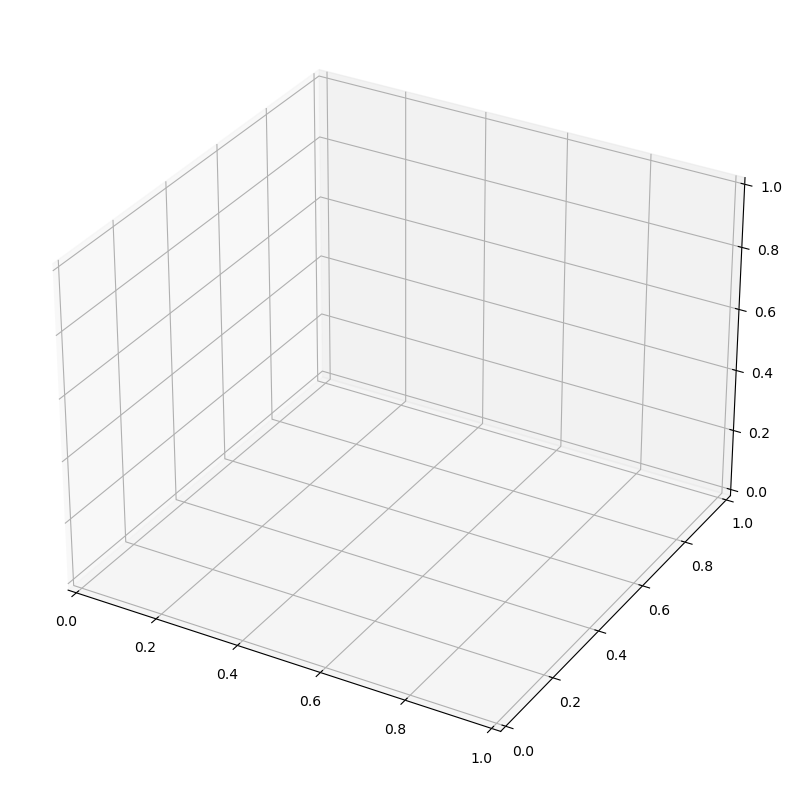

In [226]:
# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extracting data for the axes
x = g_df_with_implied_vol['strike']
y = g_df_with_implied_vol['timeToExpiry']
z = g_df_with_implied_vol['impliedVolatility']

# Creating a meshgrid for the surface plot
x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), 50), 
                             np.linspace(y.min(), y.max(), 50))
z_grid = griddata((x, y), z, (x_grid, y_grid), method='cubic')

# Plotting
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='white',linewidth=0.1)
# surf = ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1, linewidth=0.1)

# Setting labels
ax.set_xlabel('Strike')
ax.set_ylabel('Years to Expiry')
ax.set_zlabel('Implied Volatility')

# Adding a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

# Showing the plot
plt.show()

In [ ]:
z_grid

## Question Two
1. Plot the volatility smile of the first nine expiries in a 3x3 grid
    - title = expiry date
    - put options color = red
    - call option color = blue
2. Fit a 2nd degree polynomial to each volatility smile by expiry (include both puts and calls when fitting)
3. Plot the fitted line in black from the min to max strike using 100 points
4. Return the polynomial coefficients of the first nine expiries in the ExpiryCoefficients data class

In [2]:
@dataclass
class ExpiryCoefficients:
    expiry: datetime
    a: float
    b: float
    c: float


def question_two(df_options: pd.DataFrame) -> List[ExpiryCoefficients]:
    pass

g_question_two_output_path = 'question_two.csv'
g_coefficients = question_two(g_df_with_implied_vol)
if g_coefficients is not None:
    g_df_question_two = pd.DataFrame(g_coefficients)
    g_df_question_two.to_csv(g_question_two_output_path, index_label='index')

NameError: name 'dataclass' is not defined

## Question Three

1. Extend the dataframe with the 'fairValue' price of the option using a volatility interpolated from your fitted curve
2. Extend the dataframe with the absolute value of the 'mispricing' your counterparty has made
3. Extend the dataframe with 'delta' required to hedge the option if the mispricing is greater than 5 cents, if the mispricing is less than or equal to 5 cents, set the 'delta' value to np.nan

Note: You're taking the other side of the counterparty's buy/sell.


In [3]:
def question_three(expiry_coefficients, inefficient_market):
    pass


g_output_filename_counterparty = 'counterparty_options_data.csv'
g_inefficient_market = pd.read_csv(g_output_filename_counterparty, parse_dates=['today', 'expiration'], index_col='index')
g_inefficient_market_with_hedges = question_three(g_coefficients, g_inefficient_market)
if g_inefficient_market_with_hedges is not None:
    g_question_three_output_path = 'question_three.csv'
    g_inefficient_market_with_hedges.to_csv(g_question_three_output_path, index_label='index')
    print(g_inefficient_market_with_hedges)

NameError: name 'pd' is not defined